# Fusion baseline Model (Ground)

### Libraries

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-09-17 15:45:24.626429: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 15:45:24.631672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758141924.637797  427659 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758141924.639826  427659 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-17 15:45:24.646804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Config

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
DATA_DIR = Path("../data_processed")
OUT_DIR = Path("../models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ = DATA_DIR / "ground_test_h6.parquet"
TARGET = "y_ghi_h6"

FREQ     = "10min"
SEQ_LEN  = 12

### Hyperparameters

In [4]:
BATCH_SIZE = 100
EPOCHS = 50
PATIENCE = 15
LEARNING_RATE = 0.001

### Data loading and preprocessing

In [5]:
train = pd.read_parquet(TRAIN_PQ).sort_index()
val   = pd.read_parquet(VAL_PQ).sort_index()
test  = pd.read_parquet(TEST_PQ).sort_index()

if TARGET not in train or TARGET not in val or TARGET not in test:
    raise KeyError(f"Target '{TARGET}' debe existir en train/val/test")

# Intersección de columnas y solo numéricas
feat_cols = sorted(list(set(train.columns) & set(val.columns) & set(test.columns) - {TARGET}))
feat_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(train[c])]

# Quitar columnas constantes
# const_cols = [c for c in feat_cols if train[c].nunique(dropna=True) <= 1]
# if const_cols:
#     feat_cols = [c for c in feat_cols if c not in const_cols]

Xtr_df, ytr = train[feat_cols], train[TARGET]
Xva_df, yva = val[feat_cols],   val[TARGET]
Xte_df, yte = test[feat_cols],  test[TARGET]

In [6]:
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr_df)
Xva = scaler.transform(Xva_df)
Xte = scaler.transform(Xte_df)

## Baseline

In [7]:
if TARGET.startswith("y_k_"):
    base_src = None
    for c in ["k_ghi","k_raw","k_ghi_lag1","k_raw_lag1"]:
        if c in test.columns:
            base_src = test[c]; break
    if base_src is None: base_src = pd.Series(np.nanmedian(ytr), index=test.index)
    y_base = base_src.clip(0, 2.0).to_numpy()
else:
    base_src = None
    for c in ["ghi_qc","ghi_sg_definitive","ghi_qc_lag1"]:
        if c in test.columns:
            base_src = test[c]; break
    if base_src is None: base_src = pd.Series(np.nanmedian(ytr), index=test.index)
    y_base = base_src.to_numpy()

rmse = lambda a,b: float(np.sqrt(mean_squared_error(a,b)))
print(f"Baseline → RMSE: {rmse(yte, y_base):.4f} | MAE: {mean_absolute_error(yte, y_base):.4f}")


Baseline → RMSE: 196.2835 | MAE: 102.1871


## Track A

In [8]:
# ------------- Track A — MLP (tabular) -------------
mlp = models.Sequential([
    layers.Input(shape=(Xtr.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1)
])
mlp.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
cb = [
    callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5),
    callbacks.ModelCheckpoint(OUT_DIR / "MLP_best.h5", monitor="val_loss", save_best_only=True)
]
mlp.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=80, batch_size=256, verbose=0, callbacks=cb)
yhat_mlp = mlp.predict(Xte, verbose=0).squeeze()
print(f"MLP       → RMSE: {rmse(yte, yhat_mlp):.4f} | MAE: {mean_absolute_error(yte, yhat_mlp):.4f} | R2: {r2_score(yte, yhat_mlp):.4f}")


I0000 00:00:1758141927.094829  427659 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1758141927.780374  429725 service.cc:148] XLA service 0x7950ac01c240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758141927.780399  429725 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-17 15:45:27.789671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758141927.831603  429725 cuda_dnn.cc:529] Loaded cuDNN version 90101
I0000 00:00:1758141928.211968  429725 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-17 15:45:29.089062: I external/lo

MLP       → RMSE: 136.7091 | MAE: 68.6122 | R2: 0.7182


## Track B

In [9]:
# ------------- Track B — Secuencial (ventanas reales) -------------
# Reempaquetar arrays escalados a DataFrames para conservar índice
Xtr_s = pd.DataFrame(Xtr, index=Xtr_df.index, columns=feat_cols)
Xva_s = pd.DataFrame(Xva, index=Xva_df.index, columns=feat_cols)
Xte_s = pd.DataFrame(Xte, index=Xte_df.index, columns=feat_cols)

# Construcción de secuencias (inline, sin función)
def build_seq_inline(X_df, y_ser, L):
    Xv, yv = X_df.values, y_ser.values
    xs, ys, idx = [], [], []
    for i in range(L-1, len(X_df)):
        block = Xv[i-L+1:i+1]
        if np.isnan(block).any(): 
            continue
        xs.append(block); ys.append(yv[i]); idx.append(X_df.index[i])
    return (np.asarray(xs, dtype="float32"),
            np.asarray(ys, dtype="float32"),
            pd.DatetimeIndex(idx))

Xtr_seq, ytr_seq, i_tr = build_seq_inline(Xtr_s, ytr, SEQ_LEN)
Xva_seq, yva_seq, i_va = build_seq_inline(Xva_s, yva, SEQ_LEN)
Xte_seq, yte_seq, i_te = build_seq_inline(Xte_s, yte, SEQ_LEN)
print("Seq shapes:", Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)

have_seq = min(map(len,[Xtr_seq, Xva_seq, Xte_seq])) > 0

Seq shapes: (57780, 12, 45) (12374, 12, 45) (12373, 12, 45)


In [14]:
print("Seq shapes:", Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape)
have_seq = min(map(len,[Xtr_seq, Xva_seq, Xte_seq])) > 0

Seq shapes: (57780, 12, 45) (12374, 12, 45) (12373, 12, 45)


## Models

In [10]:
if have_seq:
    # LSTM
    lstm = models.Sequential([layers.Input(shape=(SEQ_LEN, Xtr_seq.shape[2])), layers.LSTM(64), layers.Dense(1)])
    lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
    es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    lstm.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq), epochs=60, batch_size=256, verbose=0, callbacks=[es])
    yhat_lstm = lstm.predict(Xte_seq, verbose=0).squeeze()
    print(f"LSTM      → RMSE: {rmse(yte_seq, yhat_lstm):.4f} | MAE: {mean_absolute_error(yte_seq, yhat_lstm):.4f} | R2: {r2_score(yte_seq, yhat_lstm):.4f}")

    # BiLSTM
    bilstm = models.Sequential([layers.Input(shape=(SEQ_LEN, Xtr_seq.shape[2])),
                                layers.Bidirectional(layers.LSTM(64)), layers.Dense(1)])
    bilstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
    bilstm.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq), epochs=60, batch_size=256, verbose=0, callbacks=[es])
    yhat_bi = bilstm.predict(Xte_seq, verbose=0).squeeze()
    print(f"BiLSTM    → RMSE: {rmse(yte_seq, yhat_bi):.4f} | MAE: {mean_absolute_error(yte_seq, yhat_bi):.4f} | R2: {r2_score(yte_seq, yhat_bi):.4f}")

    # CNN-LSTM
    cnnlstm = models.Sequential([
        layers.Input(shape=(SEQ_LEN, Xtr_seq.shape[2])),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(64),
        layers.Dense(1)
    ])
    cnnlstm.compile(optimizer="adam", loss="mse", metrics=["mae"])
    cnnlstm.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq), epochs=60, batch_size=256, verbose=0, callbacks=[es])
    yhat_cnn = cnnlstm.predict(Xte_seq, verbose=0).squeeze()
    print(f"CNN-LSTM  → RMSE: {rmse(yte_seq, yhat_cnn):.4f} | MAE: {mean_absolute_error(yte_seq, yhat_cnn):.4f} | R2: {r2_score(yte_seq, yhat_cnn):.4f}")

    # -------- Transformer (simple, sin PE explícito) --------
    inp = layers.Input(shape=(SEQ_LEN, Xtr_seq.shape[2]))
    x   = layers.Dense(64)(inp)  # proyección
    x2  = layers.MultiHeadAttention(num_heads=4, key_dim=16, dropout=0.1)(x, x)
    x   = layers.Add()([x, x2]); x = layers.LayerNormalization()(x)
    ff  = layers.Dense(128, activation="relu")(x)
    ff  = layers.Dense(64)(ff)
    x   = layers.Add()([x, ff]); x = layers.LayerNormalization()(x)
    x   = layers.GlobalAveragePooling1D()(x)
    x   = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1)(x)
    transformer = models.Model(inp, out)
    transformer.compile(optimizer="adam", loss="mse", metrics=["mae"])
    transformer.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
    yhat_tr = transformer.predict(Xte_seq, verbose=0).squeeze()
    print(f"Transformer → RMSE: {rmse(yte_seq, yhat_tr):.4f} | MAE: {mean_absolute_error(yte_seq, yhat_tr):.4f} | R2: {r2_score(yte_seq, yhat_tr):.4f}")


LSTM      → RMSE: 151.1868 | MAE: 79.7940 | R2: 0.6555
BiLSTM    → RMSE: 278.7394 | MAE: 139.8682 | R2: -0.1709
CNN-LSTM  → RMSE: 288.9287 | MAE: 147.3046 | R2: -0.2580


2025-09-17 15:46:15.656108: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 32 bytes spill stores, 32 bytes spill loads

2025-09-17 15:46:15.811118: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-09-17 15:46:17.948097: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 32 bytes spill stores, 32 bytes spill loads

2025-09-17 15:46:19.783620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 12 bytes spill stores, 12 bytes spill loads

2025-09-17 15:46:19.948603: I external/local_xla/xla/stream_executor/cud

Transformer → RMSE: 143.7744 | MAE: 73.8383 | R2: 0.6885


### Training & Evaluation

In [11]:
def skill(y_true, y_pred, y_base): return 1.0 - (rmse(y_true, y_pred) / rmse(y_true, y_base))

print(f"Skill (MLP vs base): {skill(yte, yhat_mlp, y_base):.3f}")
if have_seq:
    y_base_seq = pd.Series(y_base, index=Xte_df.index).reindex(i_te).to_numpy()
    print(f"Skill (LSTM vs base):      {skill(yte_seq, yhat_lstm, y_base_seq):.3f}")
    print(f"Skill (BiLSTM vs base):    {skill(yte_seq, yhat_bi,   y_base_seq):.3f}")
    print(f"Skill (Transformer vs base):{skill(yte_seq, yhat_tr,  y_base_seq):.3f}")
    print(f"Skill (CNN-LSTM vs base):  {skill(yte_seq, yhat_cnn,  y_base_seq):.3f}")


Skill (MLP vs base): 0.304
Skill (LSTM vs base):      0.230
Skill (BiLSTM vs base):    -0.419
Skill (Transformer vs base):0.268
Skill (CNN-LSTM vs base):  -0.471


## Visualization

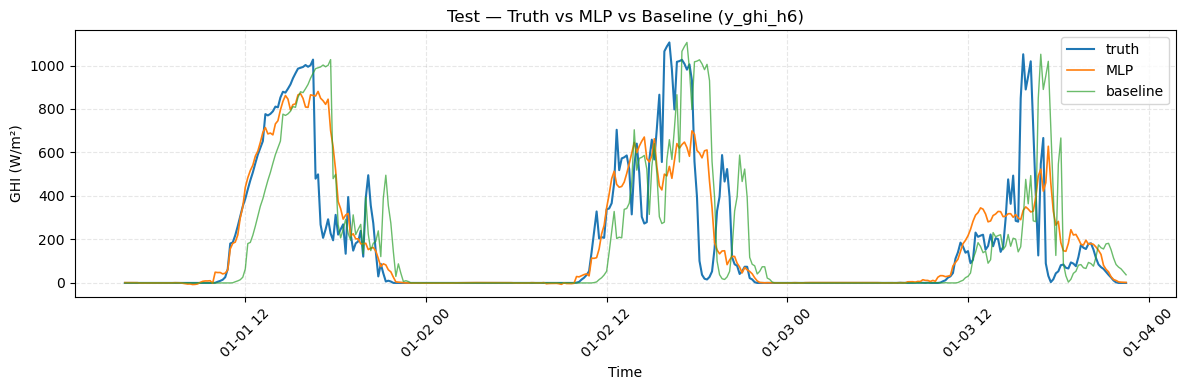

In [12]:
plt.figure(figsize=(12, 4))

plt.plot(test.index[:400], yte.values[:400], label="truth", lw=1.5)
plt.plot(test.index[:400], yhat_mlp[:400], label="MLP", lw=1.2)
plt.plot(test.index[:400], y_base[:400], label="baseline", lw=1.0, alpha=0.7)

plt.title(f"Test — Truth vs MLP vs Baseline ({TARGET})")
plt.ylabel("GHI (W/m²)" if TARGET.startswith("y_ghi") else "k-index")
plt.xlabel("Time")
plt.grid(True, ls="--", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

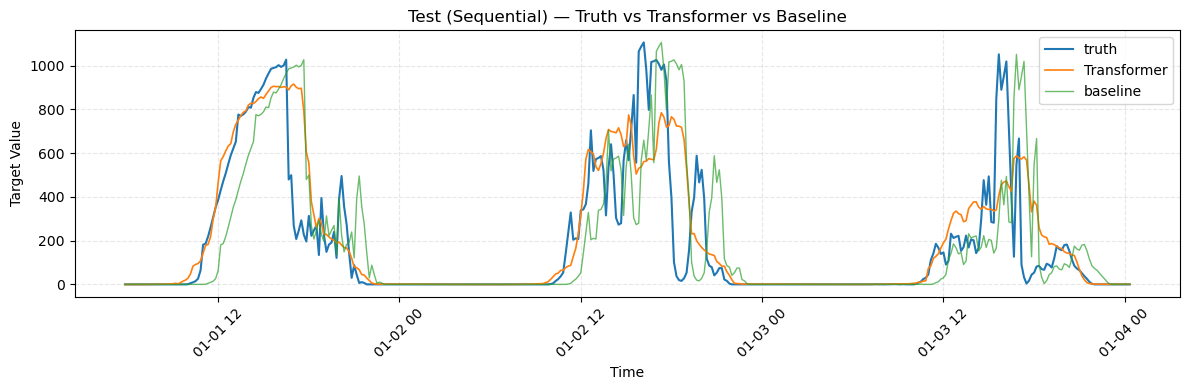

In [13]:
if have_seq:
    plt.figure(figsize=(12, 4))
    plt.plot(i_te[:400], yte_seq[:400], label="truth", lw=1.5)
    plt.plot(i_te[:400], yhat_tr[:400], label="Transformer", lw=1.2)
    plt.plot(i_te[:400], y_base_seq[:400], label="baseline", lw=1.0, alpha=0.7)
    plt.title("Test (Sequential) — Truth vs Transformer vs Baseline")
    plt.ylabel("Target Value")
    plt.xlabel("Time")
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()